# OpenAI Trading Gym Environment for Reinforcement Learning

Author: Mohammad Yousuf Hussain, CFA



Credits: HackTheMarket

Source: https://github.com/hackthemarket/gym-trading
        

This gym implements a very simple trading environment for reinforcement learning.

The gym provides daily observations based on real market data pulled from Quandl on, by default, the SPY etf. An episode is defined as 252 contiguous days sampled from the overall dataset. Each day is one 'step' within the gym and for each step, the algo has a choice:

- SHORT (0)
- FLAT (1)
- LONG (2)

If you trade, you will be charged, by default, 10 BPS of the size of your trade. Thus, going from short to long costs twice as much as going from short to/from flat. Not trading also has a default cost of 1 BPS per step. Nobody said it would be easy!

At the beginning of your episode, you are allocated 1 unit of cash. This is your starting Net Asset Value (NAV).

## Win Criteria: Outperform 'Buy and Hold'

For our purposes, we'll say that beating a buy & hold strategy, on average, over one hundred episodes will notch a win to the proud ai player. We'll illustrate exactly what that means below.

#### Dependencies for Creating the Environment

In [9]:
import gym
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

In [55]:
import gym_trading
env = gym.make('trading-v0')
#env.time_cost_bps = 0 #

[2018-01-30 11:54:58,095] Making new env: trading-v0


#### Trading Model

Each time step is a day. Each episode is 252 trading days - a year. Each day, we can choose to be short (0), flat (1) or long (2) the single instrument in our trading universe.

Let's run through a day and stay flat.

Annualized return:  -0.0247888380589


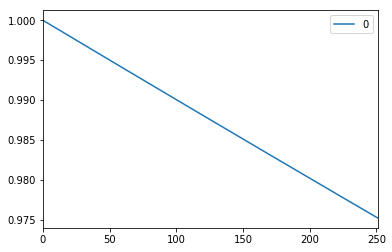

In [14]:
observation = env.reset()
done = False
navs = []
while not done:
    action = 1 # stay flat
    observation, reward, done, info = env.step(action)
    navs.append(info['nav'])
    if done:
        print ('Annualized return: ',navs[len(navs)-1]-1)
        pd.DataFrame(navs).plot()

#### Note that you are charged just for playing - to the tune of 1 basis point per day!

#### Utility Methods

Although the gym can be 'exercised' directly as seen above, we've also written utility methods which allow for the running of a strategy once or over many episodes, facilitating training or other sorts of analysis.

To utilize these methods, strategies should be exposed as a function or lambda with the following signature:

Action a = strategy( observation, environment )

Below, we define some simple strategies and look briefly at their behavior to better understand the trading gym.

   action   bod_nav   mkt_nav  mkt_return  sim_return  position   costs  trade
0     2.0  1.000000  1.000000   -0.000559   -0.001100       1.0  0.0011    1.0
1     2.0  0.998900  0.999441   -0.020145   -0.020245       1.0  0.0001    0.0
2     2.0  0.978677  0.979306    0.014849    0.014749       1.0  0.0001    0.0
3     2.0  0.993111  0.993848    0.012943    0.012843       1.0  0.0001    0.0
4     2.0  1.005866  1.006711   -0.050556   -0.050656       1.0  0.0001    0.0


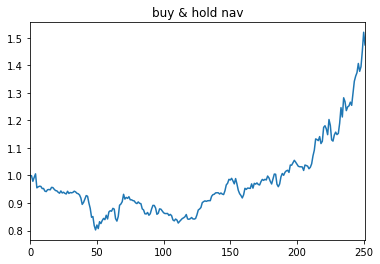

In [31]:

import gym_trading.envs.trading_env as te

env = env.unwrapped

stayflat     = lambda o,e: 1   # stand pat
buyandhold   = lambda o,e: 2   # buy on day #1 and hold
randomtrader = lambda o,e: e.action_space.sample() # retail trader

# to run singly, we call run_strat.  we are returned a dataframe containing 
#  all steps in the sim.
bhdf = env.run_strat(buyandhold)

print (bhdf.head())

# we can easily plot our nav in time:
bhdf.bod_nav.plot(title='buy & hold nav')

#### Running the same strategy multiple times will likely yield different results as underlying data changes

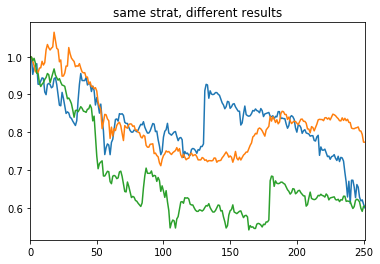

In [32]:

env.run_strat(buyandhold).bod_nav.plot(title='same strat, different results')
env.run_strat(buyandhold).bod_nav.plot()
env.run_strat(buyandhold).bod_nav.plot()

#### Comparing 'Buy and Hold' and 'Random Trader'

In [37]:
# running a strategy multiple times should yield insights 
#   into its expected behavior or give it oppty to learn
bhdf = env.run_strat(buyandhold,100)
rdf = env.run_strat(randomtrader,100)

comparo = pd.DataFrame({'buyhold':bhdf.mean(),
                        'random': rdf.mean()})
comparo

,buyhold,random
action,2.000000,0.908730
bod_nav,1.238212,0.842703
mkt_nav,1.266374,1.419809
mkt_return,0.002638,0.001378
sim_return,0.002499,-0.000910
position,1.000000,-0.091270
costs,0.000104,0.000969
trade,0.003968,0.003968


#### Game Objectives

From the above examples, we can see that buying and holding will, over the long run, give you the market return with low costs.

Randomly trading will instead destroy value rather quickly as costs overwhelm.

#### What does it mean to win the trading game?

For our purposes, we'll say that beating a buy & hold strategy, on average, over one hundred episodes will notch a win to the proud ai player.

To support this, the trading environment maintains the mkt_return which can be compared with the sim_return.

Note that the mkt_return is frictionless while the sim_return incurs both trading costs and the decay cost of 1 basis point per day, so overcoming the hurdle we've set here should be challenging.

In [63]:
import tensorflow as tf
import gym_trading.envs.policy_gradient as policy_gradient

In [64]:
import gym_trading
env = gym.make('trading-v0')

[2018-01-30 20:03:18,448] Making new env: trading-v0


In [75]:
tf.reset_default_graph()
#env = env.unwrapped
# create the tf session
sess = tf.InteractiveSession()

# create policygradient
pg = policy_gradient.PolicyGradient(sess, obs_dim=5, num_actions=3, learning_rate=1e-2 )

# and now let's train it and evaluate its progress.  NB: this could take some time...
df,sf = pg.train_model( env,episodes=100, log_freq=10)#, load_model=True)

[2018-01-31 11:29:53,844] year #     0, mean reward:  -0.0022, sim ret:  -0.2373, mkt ret:   0.0174, net:  -0.2547
[2018-01-31 11:29:55,410] year #    10, mean reward:  -0.0191, sim ret:  -0.1601, mkt ret:   0.2344, net:  -0.3945
[2018-01-31 11:29:56,965] year #    20, mean reward:  -0.0187, sim ret:  -0.4688, mkt ret:  -0.4553, net:  -0.0134
[2018-01-31 11:29:58,506] year #    30, mean reward:  -0.0114, sim ret:   0.1834, mkt ret:   0.4786, net:  -0.2951
[2018-01-31 11:30:00,080] year #    40, mean reward:   0.0005, sim ret:   0.3475, mkt ret:   0.0692, net:   0.2783
[2018-01-31 11:30:01,885] year #    50, mean reward:   0.0005, sim ret:  -0.0033, mkt ret:  -0.1647, net:   0.1614
[2018-01-31 11:30:03,525] year #    60, mean reward:   0.0154, sim ret:   0.1340, mkt ret:   0.5202, net:  -0.3862
[2018-01-31 11:30:05,085] year #    70, mean reward:   0.0267, sim ret:   0.3618, mkt ret:   0.3333, net:   0.0285
[2018-01-31 11:30:06,672] year #    80, mean reward:   0.0245, sim ret:  -0.0355

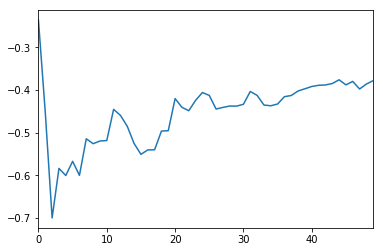

In [69]:
sf['net'] = sf.simror - sf.mktror
#sf.net.plot()
sf.net.expanding().mean().plot()
sf.net.rolling(100).mean().plot()

In [62]:
sf.net.rolling(100).mean().tail()

495    0.004557
496    0.005043
497    0.003307
498   -0.000629
499   -0.000421
Name: net, dtype: float64